# Post-stack inversion with proximal solvers - Hess model (with model fluctuations)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')
import collections

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import segyio

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.basicoperators import VStack as VStacklop


from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

from htracker.jointinv import joint_inversion_segmentation
from htracker.workflows import *

np.random.seed(10)

plt.style.use('seaborn-ticks')
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)

In [2]:
os.environ['NUMBA_NUM_THREADS'] = '6'

In [3]:
def callback(x, xhist):
    xhist.append(x)

In [4]:
def RRE(x, xinv):
    return np.linalg.norm(x-xinv) / np.linalg.norm(x)

In [5]:
def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv)**2 / np.linalg.norm(x-xinv)**2)

In [6]:
rre = {}
psnr = {}

## Hess model

In [7]:
f = segyio.open('../data/timodel_vp.segy', ignore_geometry=True)
v = segyio.collect(f.trace[:]).T
v = np.pad(v, ((80, 0), (0, 0)), constant_values=v[0, 0])
v = v[::8, ::8]

nt0, nx = v.shape
dt0 = 0.008
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

rho = 2000.
m = np.log(v*rho)

Refine grid

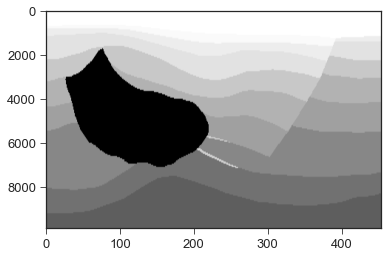

In [8]:
dt0fine = dt0/50
nt0fine = nt0*50
t0fine = np.arange(nt0fine)*dt0fine

vfine = np.vstack([np.interp(t0fine, t0, v[:, ix]) for ix in range(nx)]).T
mfine = np.log(vfine*rho)

plt.imshow(vfine)
plt.axis('tight');

Identify classes

In [9]:
collections.Counter(m.ravel())

Counter({16.118093: 9072,
         16.198013: 2313,
         16.360882: 3430,
         16.448978: 7330,
         16.60986: 8021,
         17.203283: 11646,
         16.705547: 6867,
         16.767603: 6344,
         16.853342: 11998,
         16.56278: 140,
         16.922604: 10270,
         16.983343: 12263})

In [10]:
allcl = np.unique(m)
nclmin = 3000
cl = np.array(list(filter(lambda x: np.count_nonzero(m.ravel() == x) > nclmin, allcl)))
ncl = len(cl)

In [11]:
len(allcl), ncl

(12, 10)

In [12]:
vcl_true = np.zeros_like(m)

for icl in range(ncl):
    vcl_true[m == cl[icl]] = icl
vcl_true_fine = np.vstack([np.interp(t0fine, t0, vcl_true[:, ix]) for ix in range(nx)]).T

Add small variations with different correlation lenght per class

In [13]:
mfine1 = np.copy(mfine)
sigmas = np.array([0.9, 1.2, 1., 1.4, 1.2, 0.9, 0.6, 0.4, 0.9, 0.0])/1.5
smoothsx = [5, 15, 22, 10, 7, 4, 6, 6, 5, 30]
smoothsy = [20, 16, 28, 22, 20, 15, 20, 18, 18, 15]
for icl, (sig, smoothx, smoothy) in enumerate(zip(sigmas, smoothsx, smoothsy)):
    n = np.random.normal(0, sig, mfine.shape)
    n = gaussian_filter(n, sigma=(smoothy, smoothx))
    mfine1[vcl_true_fine == icl] += n[vcl_true_fine == icl]

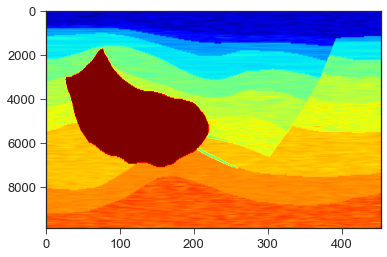

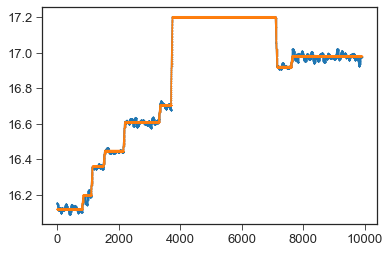

In [14]:
plt.figure()
plt.imshow(mfine1, cmap='jet')
plt.axis('tight');

plt.figure()
plt.plot(mfine1[:, nx//3], '.-', ms=1)
plt.plot(mfine[:, nx//3], '.-', ms=1);

In [15]:
mfine = mfine1.copy()

Estimate classes from perturbed log

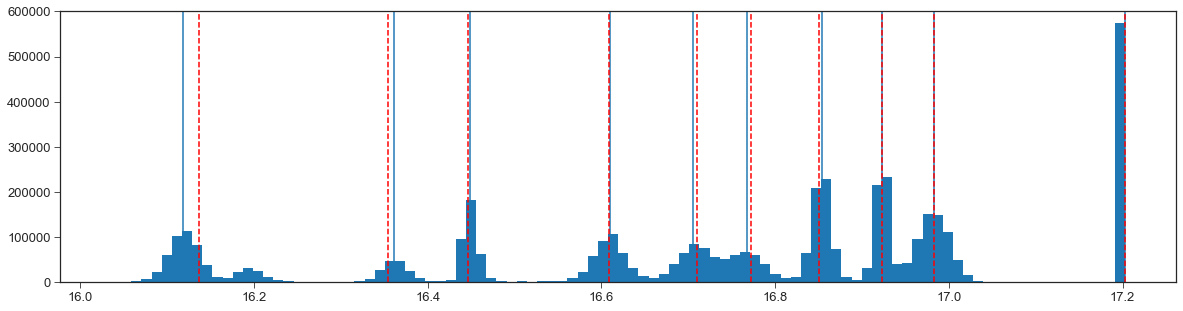

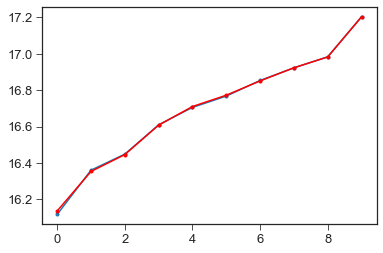

In [16]:
from sklearn.cluster import KMeans

mwells = np.hstack((mfine1[:, nx//3], mfine1[:, nx//2+50]))
km = KMeans(len(cl))
km.fit(mwells.reshape(-1, 1))
cl_est = np.array(sorted(list(km.cluster_centers_.ravel())))

plt.figure(figsize=(20, 5))
plt.hist(mfine1.ravel(), bins=100);
for c in cl:
    plt.axvline(c)
for c in cl_est:
    plt.axvline(c, color='r', ls='--')
    
plt.figure()
plt.plot(cl, '.-')
plt.plot(cl_est, '.-r')

True horizons

In [17]:
hors = {}
for icl in range(ncl-2):
    mclass = (vcl_true == icl).astype(np.int)
    
    cabove = np.zeros(nx)
    cbelow = np.zeros(nx)
    hor = -1 * np.ones(nx)
    for ix in range(nx):
        it = np.where(np.diff(mclass[:, ix]) == -1)[0]
        if len(it) > 0:
            hor[ix] = it[0 if icl==0 else -1] # quick hack
            cabove[ix] = vcl_true[it[0 if icl==0 else -1] - 1, ix]
            cbelow[ix] = vcl_true[it[0 if icl==0 else -1] + 1, ix]
    cabove_sel = sp.stats.mode(cabove)[0]
    cbelow_sel = sp.stats.mode(cbelow)[0]
    
    mask = hor >= 0
    for ix in range(nx):
        if cabove[ix] != cabove_sel or cbelow[ix] != cbelow_sel:
            mask[ix] = False
    hor = np.interp(np.arange(nx), np.arange(nx)[mask], hor[mask])
    hor[~mask] = np.nan
    hors['a%db%d' % (cabove_sel, cbelow_sel)] = hor

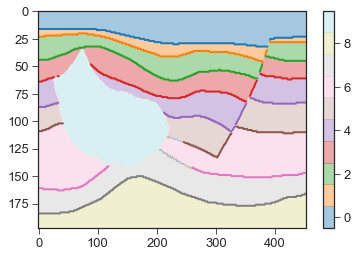

In [18]:
plt.figure()
plt.imshow(vcl_true.reshape(nt0, nx),
           cmap=cm.get_cmap('tab20', ncl), 
           vmin=-0.5, vmax=ncl-0.5, alpha=0.4)
plt.axis('tight')
for icl in list(hors.keys()):
    plt.plot(np.arange(nx), hors[icl], lw=2)
plt.colorbar();

Compute data

In [19]:
# smooth model
nsmooth = 30
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1,
                 filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0), axis=1)

# wavelet
ntwav = 2001
wavfine, twav, wavc = ricker(t0fine[:ntwav//2+1], 8)
wav = wavfine[::50]

# operator
Lopfine = PoststackLinearModelling(wavfine / 2, nt0=nt0fine, spatdims=nx)
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
dfine = Lopfine * mfine.ravel()
dfine = dfine.reshape(nt0fine, nx)
d = dfine[::50].ravel()

# colored noise
sigman = 1e-1
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust').ravel()
dn = d + n

# background data
dback = Lop * mback.ravel()

d = d.reshape(nt0, nx)
dn = dn.reshape(nt0, nx)
dback = dback.reshape(nt0, nx)

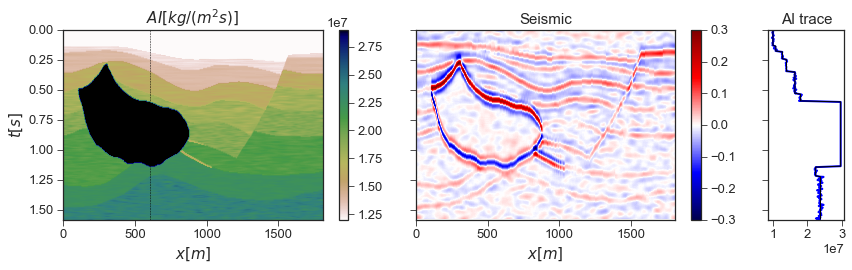

In [20]:
cmap='gist_earth_r'

fig, axs = plt.subplots(1, 3, sharey=True, 
                        gridspec_kw={'width_ratios': [3, 3, 0.7]}, figsize=(12, 4))
im = axs[0].imshow(np.exp(mfine), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0fine[-1], t0fine[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'$AI [kg/(m^2s)]$')
im = axs[1].imshow(dn, cmap='seismic', vmin=-0.3, vmax=0.3, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Seismic')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(np.exp(mfine[:, nx//3]), t0fine, 'b', lw=2)
axs[2].plot(np.exp(m[:, nx//3]), t0, 'k', lw=1)
axs[2].axis('tight')
axs[2].set_title('AI trace')
plt.tight_layout()
plt.savefig('Figs/Hesspert_modeldata.eps', dpi=300);

## 2D Post-stack inversion

In [21]:
# L2 regularized inversion
Dop = Laplacian(dims=(nt0, nx), dtype=Lop.dtype)
minv = RegularizedInversion(Lop, [Dop], dn.ravel(),
                            x0=mback.ravel(), epsRs=[2.], returninfo=False, show=False,
                            **dict(iter_lim=100, damp=1e-4))
dinv = Lop*minv

minv = minv.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['L2'] = RRE(m.ravel(), minv.ravel())
psnr['L2'] = PSNR(m.ravel(), minv.ravel())
print('RRE=', rre['L2'])
print('PSNR=', psnr['L2'])

RRE= 0.002952381090837037
PSNR= 50.85482551039653


In [22]:
# SplitBregman (Blockiness-promoting inversion with anisotropic TV)
RegL1op = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
msb = SplitBregman(Lop, [RegL1op], dn.ravel(),
                   epsRL1s=[0.03], mu=0.3,
                   niter_outer=5,
                   niter_inner=10,
                   x0=mback.ravel(), show=True,
                   **dict(iter_lim=5, damp=1e-4))[0]
dinv = Lop*msb

msb = msb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['SB'] = RRE(m.ravel(), msb.ravel())
psnr['SB'] = PSNR(m.ravel(), msb.ravel())
print('RRE=', rre['SB'])
print('PSNR=', psnr['SB'])

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 89694 rows and 89694 cols
niter_outer =   5     niter_inner =  10   tol = 1.00e-10
mu = 3.00e-01         epsL1 = [0.03]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   1.62947e+01        3.134e-01        1.417e+03
     2   1.62865e+01        3.265e-01        1.258e+03
     3   1.62741e+01        3.438e-01        1.183e+03
     4   1.62742e+01        3.585e-01        1.138e+03
     5   1.62807e+01        3.692e-01        1.107e+03

Iterations = 5        Total time (s) = 2.38
---------------------------------------------------------

RRE= 0.0024983090864693805
PSNR= 52.31255385683559


In [23]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

sigma=0.04
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=10, warm=True)

# steps
L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

mladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=mback.ravel(), niter=100, show=True)[0]
dinv = Lop*mladmm

mladmm = mladmm.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['LADMM'] = RRE(m.ravel(), mladmm.ravel())
psnr['LADMM'] = PSNR(m.ravel(), mladmm.ravel())
print('RRE=', rre['LADMM'])
print('PSNR=', psnr['LADMM'])

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.237500e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.61188e+01   5.367e+01   2.129e+01   7.496e+01
     2   1.61210e+01   4.296e+01   2.216e+01   6.512e+01
     3   1.61244e+01   3.549e+01   2.316e+01   5.865e+01
     4   1.61287e+01   2.998e+01   2.411e+01   5.409e+01
     5   1.61336e+01   2.581e+01   2.494e+01   5.075e+01
     6   1.61387e+01   2.265e+01   2.558e+01   4.822e+01
     7   1.61434e+01   2.022e+01   2.608e+01   4.630e+01
     8   1.61473e+01   1.832e+01   2.650e+01   4.482e+01
     9   1.61506e+01   1.681e+01   2.685e+01   4.366e+01
    10   1.61532e+01   1.557e+01   2.711e+01   4.269e+01
    11   1.61555e+01   1.455e+01   2.731e+01   4.186e+01
    2

In [24]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, mback.ravel(), tau=tau, mu=mu, 
                 theta=1., niter=100, show=True)
dinv = Lop*mpd

mpd = mpd.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['PD'] = RRE(m.ravel(), mpd.ravel())
psnr['PD'] = PSNR(m.ravel(), mpd.ravel())
print('RRE=', rre['PD'])
print('PSNR=', psnr['PD'])

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.237500e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.61234e+01   1.986e+01   7.315e+00   0.000e+00       2.717e+01
     2   1.61342e+01   9.569e+00   8.818e+00   0.000e+00       1.839e+01
     3   1.61474e+01   6.398e+00   9.374e+00   0.000e+00       1.577e+01
     4   1.61613e+01   5.007e+00   9.513e+00   0.000e+00       1.452e+01
     5   1.61739e+01   4.249e+00   9.466e+00   0.000e+00       1.372e+01
     6   1.61853e+01   3.783e+00   9.341e+00   0.000e+00       1.312e+01
     7   1.61950e+01   3.473e+00   9.237e+00   0.000e+00       1.271e+01
     8   1.62028e+01   3.254e+00   9

In [25]:
pd.Series(psnr)

L2       50.854826
SB       52.312554
LADMM    52.296707
PD       53.692429
dtype: float64

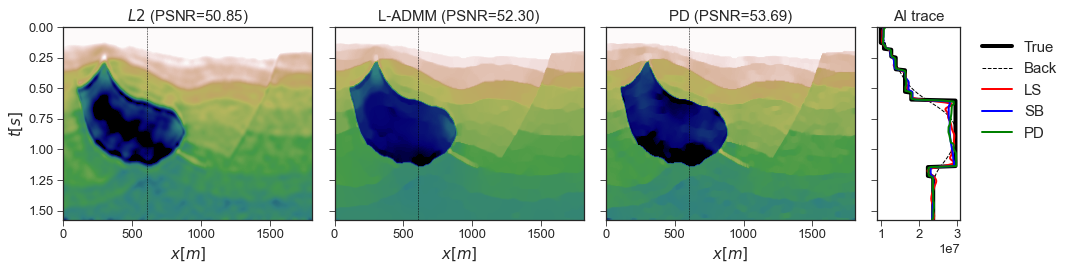

In [26]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 4),
                        gridspec_kw={'width_ratios': [3, 3, 3, 1]})
axs[0].imshow(np.exp(minv), vmin=1.2e7, vmax=2.9e7,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'$L2$ (PSNR=%.2f)' % psnr['L2'])
axs[1].imshow(np.exp(mladmm), vmin=1.2e7, vmax=2.9e7,
              cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('L-ADMM (PSNR=%.2f)' % psnr['LADMM'])
axs[1].axis('tight')
axs[2].imshow(np.exp(mpd), vmin=1.2e7, vmax=2.9e7,
              cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('PD (PSNR=%.2f)' % psnr['PD'])
axs[2].axis('tight')
axs[3].plot(np.exp(m[:, nx//3]), t0, 'k', lw=4, label='True')
axs[3].plot(np.exp(mback[:, nx//3]), t0, '--k', lw=1, label='Back')
axs[3].plot(np.exp(minv[:, nx//3]), t0, 'r', lw=2, label='LS')
axs[3].plot(np.exp(mladmm[:, nx//3]), t0, 'b', lw=2, label='SB')
axs[3].plot(np.exp(mpd[:, nx//3]), t0, 'g', lw=2, label='PD')
axs[3].legend(bbox_to_anchor=(1.1, 1.))
axs[3].axis('tight')
axs[3].set_title('AI trace')
plt.tight_layout()
plt.savefig('Figs/Hesspert_inversions.eps', dpi=150);

## 2D Post-stack segmentation

Let's start by taking one of our previous inversion results and use it as input to a segmentation algorithm

In [27]:
# Use estimated cl instead of true
cl = cl_est

In [28]:
segpd, segpd_classes = \
    Segment(mpd, cl, 20., 0.2, niter=50, show=True, 
            kwargs_simplex=dict(engine='numba',  maxiter=10, call=False))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 50

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   5.12356e-01   0.000e+00   5.032e+02   7.439e+03       7.943e+03
     2   6.02812e-01   0.000e+00   6.177e+02   4.449e+03       5.067e+03
     3   6.54172e-01   0.000e+00   6.764e+02   3.138e+03       3.815e+03
     4   7.05495e-01   0.000e+00   6.995e+02   2.562e+03       3.261e+03
     5   7.56786e-01   0.000e+00   7.154e+02   2.260e+03       2.975e+03
     6   8.08127e-01   0.000e+00   7.303e+02   2.052e+03       2.782e+03
     7   8.59849e-01   0.000e+00   7.416e+02   1.896e+03       2.638e+03
     8

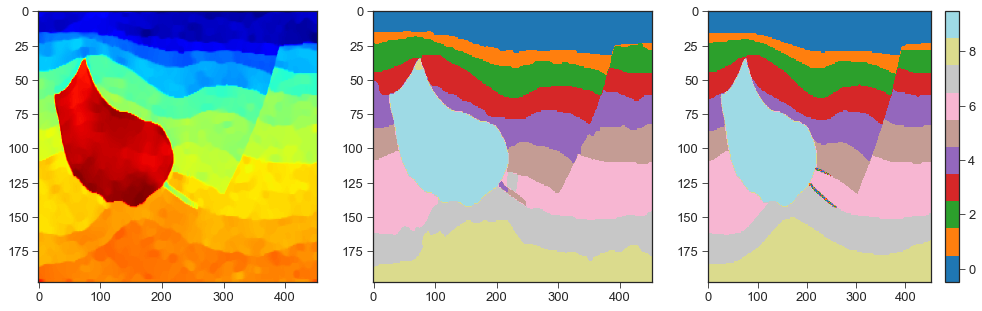

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].imshow(mpd, cmap='jet')
axs[0].axis('tight')
im=axs[1].imshow(segpd_classes, cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5)
axs[1].axis('tight')
im=axs[2].imshow(vcl_true.reshape(nt0, nx), cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5)
axs[2].axis('tight')
plt.colorbar(im);

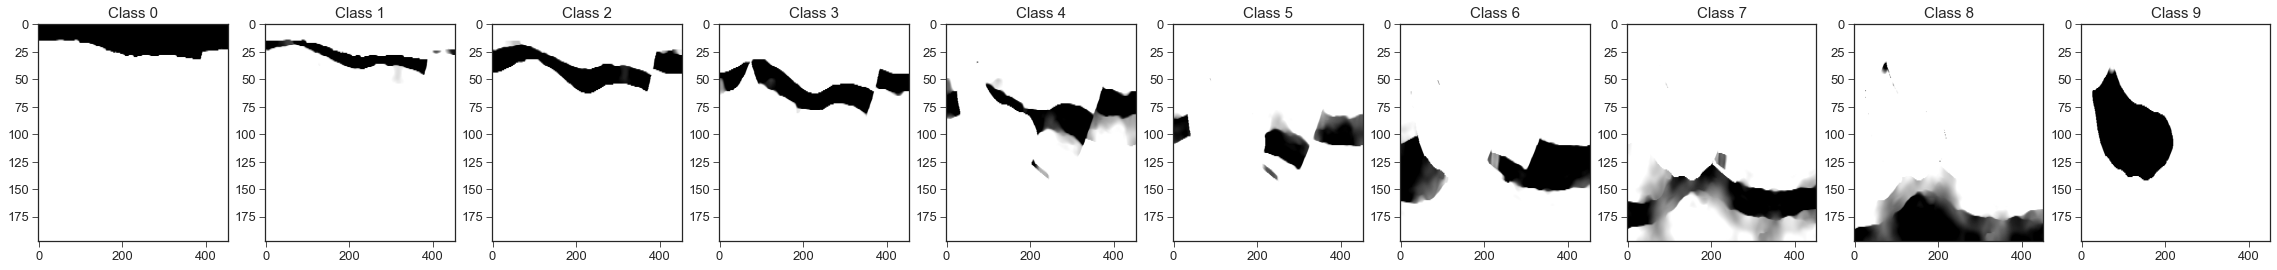

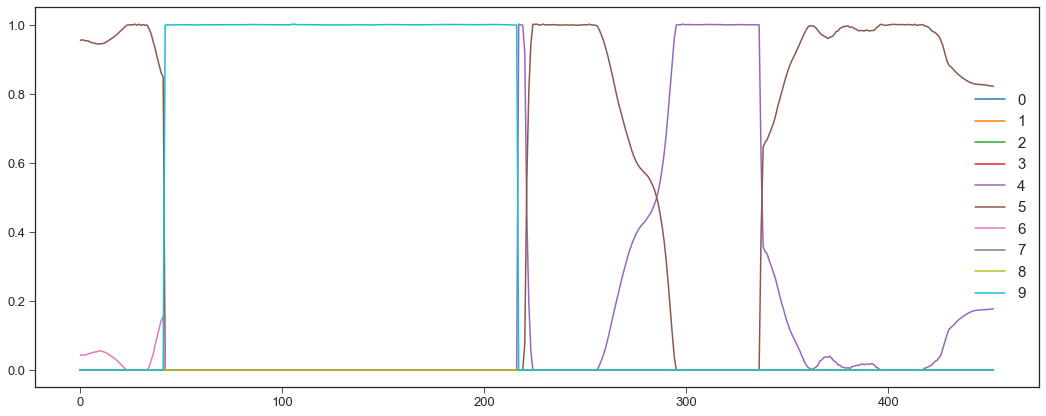

In [30]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
       
plt.figure(figsize=(18, 7))
for icl in range(ncl):
    plt.plot(segpd.reshape(nt0, nx, ncl)[100, :, icl], label=icl)
plt.legend();

### Extract horizons

In [31]:
horizon_list = multiclass_horizons(ncl, segpd_classes, 
                                   nn_lim=1, line_minlen=5, 
                                   verbose=False)

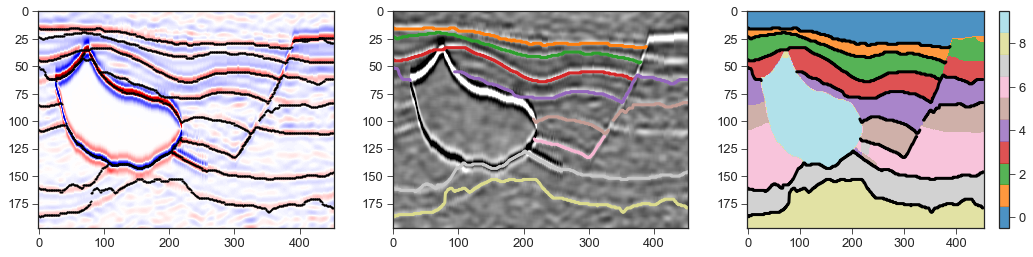

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
from matplotlib.colors import Normalize
norm = Normalize(vmin=-0.5, vmax=ncl-0.5)

ax1.imshow(d, vmin=-0.3, vmax=0.3, aspect="auto", cmap='seismic')
for i,h in horizon_list.iterrows():  
    if h['chosen']:
        ax1.scatter(h['x'], h['y'], c='k', s=1)
ax1.axis('tight')

ax2.imshow(dn, vmin=-0.1, vmax=0.1, aspect="auto", cmap='gray')
for ihor, horkey in enumerate(hors.keys()):
    horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
    if len(horsel) > 0:
        ax2.plot(horsel[0]['regx'], horsel[0]['regy'], c=cm.get_cmap('tab20', ncl)(norm(ihor+1)), lw=3)

im=ax3.imshow(segpd_classes, aspect="auto", 
              cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5, alpha=0.8)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
        if len(horsel) > 0:
            ax3.plot(horsel[0]['regx'], horsel[0]['regy'], c='k', lw=3)
plt.colorbar(im, ax=ax3)
ax3.axis('tight');

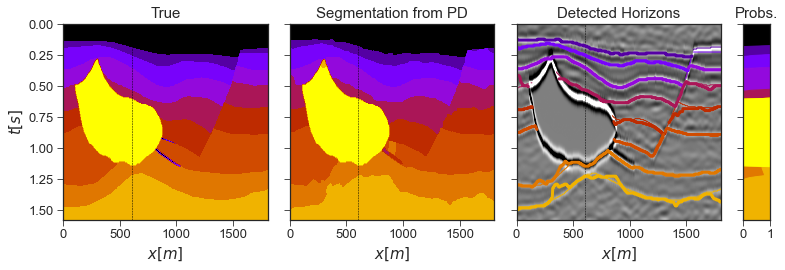

In [33]:
cmap_classes = 'gnuplot'
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(11, 4),
                        gridspec_kw={'width_ratios': [3, 3, 3, 0.4]})
axs[0].imshow(vcl_true, cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title('True')
axs[1].imshow(segpd_classes, cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Segmentation from PD')
axs[2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].axis('tight')
for ihor, horkey in enumerate(hors.keys()):
    axs[2].plot(np.arange(nx) * dx, hors[horkey]* dt0, 
                c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=1)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
        for hsel in horsel:
            axs[2].plot(hsel['regx']* dx, hsel['regy']* dt0,
                        c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=3)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('Detected Horizons')

norm = Normalize(vmin=0, vmax=ncl)
probs = segpd.reshape(nt0, nx, ncl)[:, nx//3]
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((nt0, 1)), cdf))
for icl in range(ncl):
    axs[3].fill_betweenx(t0, cdf[:, icl], cdf[:, icl+1], 
                         color=cm.get_cmap(cmap_classes, ncl)(norm(icl)))
axs[3].set_xlim(0, 1)
axs[3].set_title('Probs.')
plt.tight_layout()
plt.savefig('Figs/Hesspert_segmentation.eps', dpi=150);

## 2D Post-stack joint inversion & segmentation

**Inversion**

$$
m^{k+1} = min_x  (\frac{1}{2}||Ax-f||_2^2 + \delta ||\hat{V}x-\hat{c}||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

combining the first two terms

$$
m^{k+1} = min_x  (\frac{1}{2}||A^1x-f^1||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $A^1 = [A, \sqrt{2\delta}\hat{V}]^T$ and $f^1 = [f, \sqrt{2\delta}\hat{c}]^T$ and $\hat{V}=[diag(\sqrt{v_1}), ..., diag(\sqrt{v_N})]$ and $\hat{c}=[\sqrt{v_1}c_1, ..., \sqrt{v_N}c_N]$


**Segmentation**


$$
v^{k+1} = min_{v \in C}  (v^T(\delta g - \beta q^k) - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $C$ is a simplex.

Working with alpha=0.010000,  beta=0.100000,  delta=2.000000
Iteration 0...
f= 2.2831719574917226
||v-v_old||_2= 251.16290704744432
||m-m_old||_2= 17.264728795942126
RRE= 0.0021262873600622354
PSNR= 53.692429358735836
Iteration 1...
f= 6.819580222681363
||v-v_old||_2= 45.379576101233354
||m-m_old||_2= 8.657553799209092
RRE= 0.0015416812916434397
PSNR= 56.47841181620823
Iteration 2...
f= 6.925252024154108
||v-v_old||_2= 31.19148695209027
||m-m_old||_2= 2.549051664922522
RRE= 0.0014690439462528998
PSNR= 56.90152814772513
Iteration 3...
f= 6.881605652733948
||v-v_old||_2= 26.37683585265525
||m-m_old||_2= 1.6322076438274522
RRE= 0.001406678257726672
PSNR= 57.2784937092372


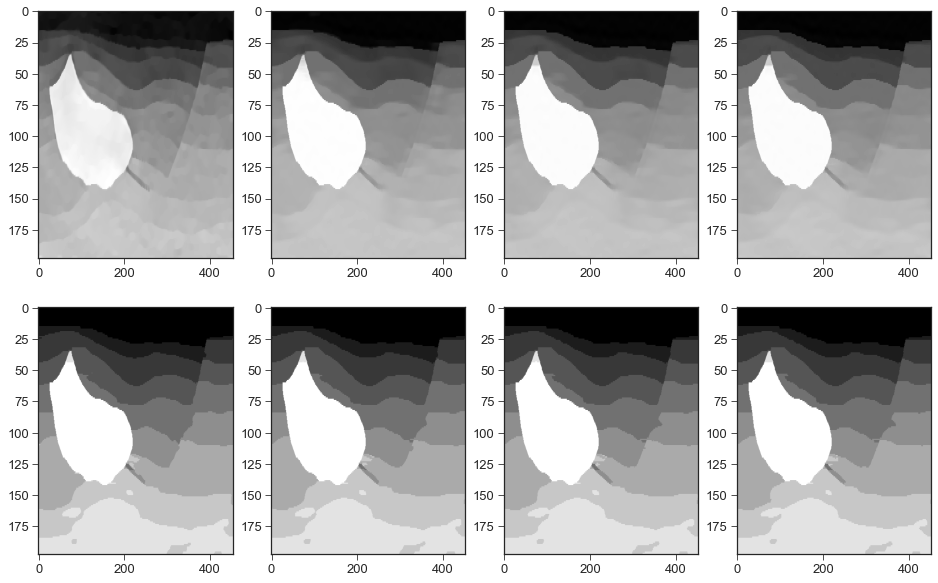

In [34]:
alpha = 0.01
beta = 0.1
delta = 2.

niter = 2
tolstop = 0.

mjoint, vjoint, vcljoint, rre['J'], psnr['J'], mjoint_hist, vjoint_hist = \
    joint_inversion_segmentation(dn, mback, cl, Lop, alpha, beta, delta, tau, mu,
                                 niter=4, l2niter=20, pdniter=100,
                                 segmentniter=50, bisectniter=10, tolstop=0.,
                                 mtrue=m, plotflag=True)

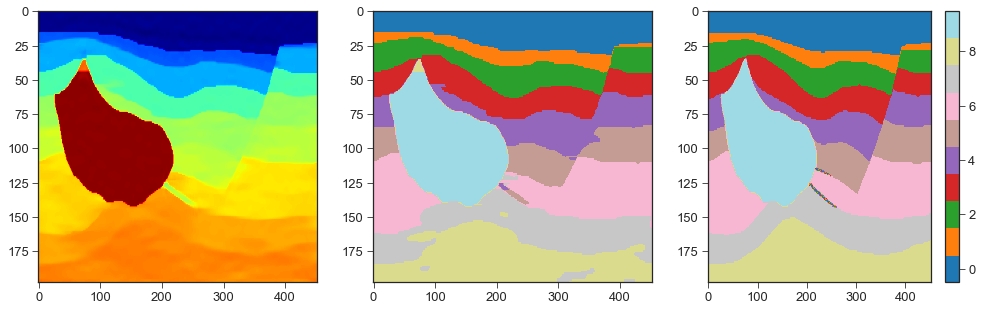

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].imshow(mjoint.reshape(nt0, nx), cmap='jet')
axs[0].axis('tight')
im=axs[1].imshow(vcljoint.reshape(nt0, nx), cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5)
axs[1].axis('tight');
im=axs[2].imshow(vcl_true.reshape(nt0, nx), cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5)
axs[2].axis('tight');
plt.colorbar(im);

[10192285.80797773 12658639.65320846 13888737.27395686 16325489.56037713
 18079814.07364129 19239680.43359264 20809607.67928237 22368307.40754927
 23734735.82660755 29583216.24016073]


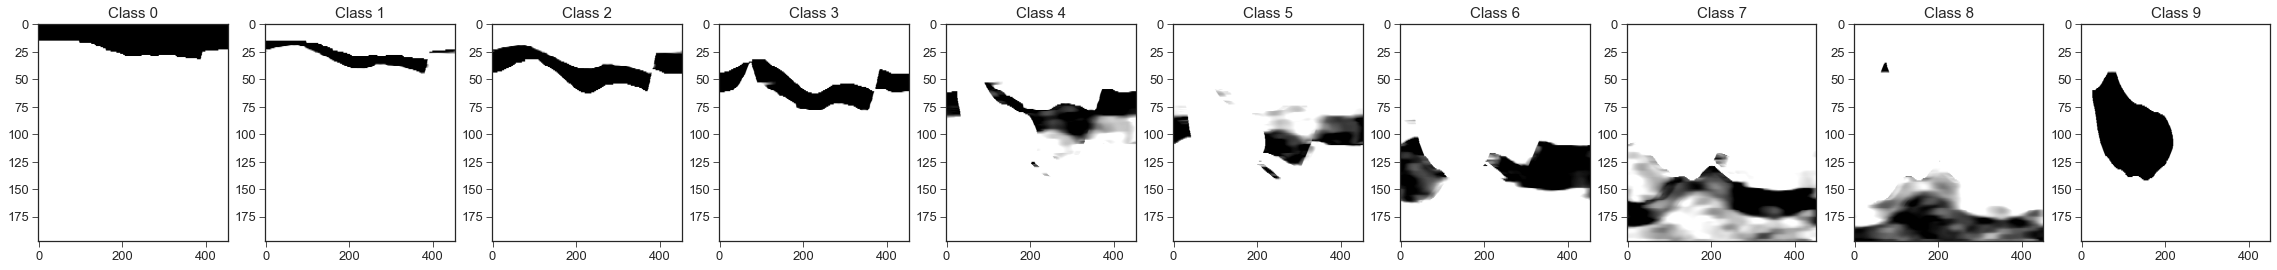

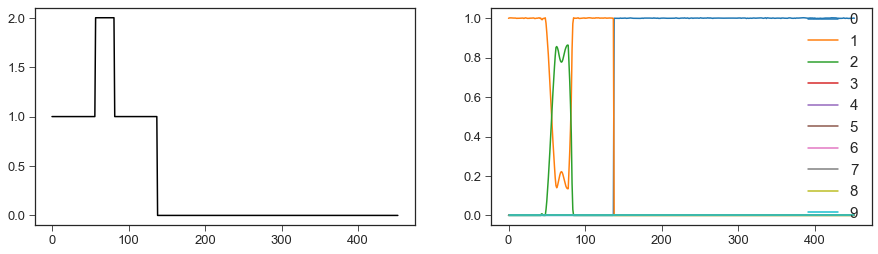

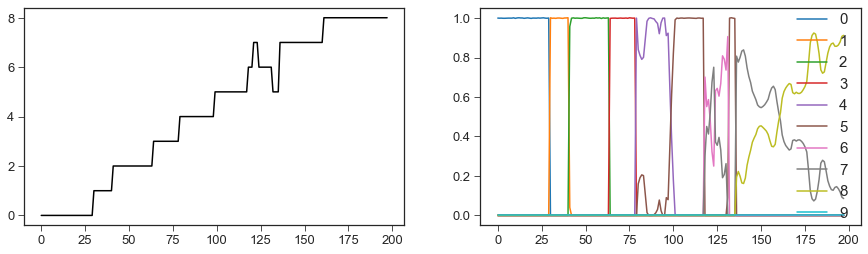

In [36]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(vjoint[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(vcljoint.reshape(nt0, nx)[20], 'k')
for icl in range(ncl):
    axs[1].plot(vjoint.reshape(nt0, nx, ncl)[20, :, icl], label=icl)
axs[1].legend(loc='right')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(vcljoint.reshape(nt0, nx)[:, nx//2], 'k')
for icl in range(ncl):
    axs[1].plot(vjoint.reshape(nt0, nx, ncl)[:, nx//2, icl], label=icl)
axs[1].legend(loc='right');

print(np.exp(cl))

Text(0.5, 0, '#Outer Iteration')

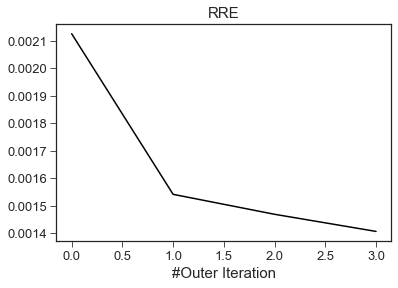

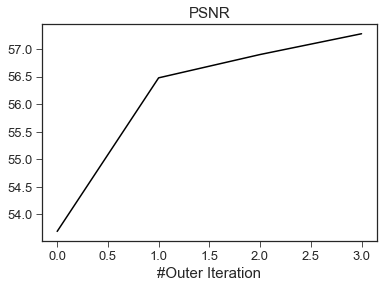

In [37]:
plt.figure()
plt.plot(rre['J'], 'k')
plt.title('RRE')
plt.xlabel('#Outer Iteration')

plt.figure()
plt.plot(psnr['J'], 'k')
plt.title('PSNR')
plt.xlabel('#Outer Iteration')

In [38]:
horizon_list = multiclass_horizons(ncl, vcljoint.reshape(nt0, nx), 
                                   nn_lim=1, line_minlen=5, 
                                   lb_lenclasscompute=100, lb_lenclasswindow=2,
                                   verbose=True)

Class: 0
Start: 2021-07-05 22:13:48.407996
Compute TV Completed: 0:00:00.004655 sec
Get horizon points Completed: 0:00:00.000372 sec
Get separated horizons Completed: 0:00:02.562805 sec
Interpolate horizons Completed: 0:00:00.000979 sec
Label horizons Completed: 0:00:00.012935 sec
Join horizons Completed: 0:00:00.007430 sec
Regredding horizons Completed: 0:00:00.001470 sec
End: 2021-07-05 22:13:50.999401
Duration: 0:00:02.591405
 
Class: 1
Start: 2021-07-05 22:13:50.999449
Compute TV Completed: 0:00:00.003385 sec
Get horizon points Completed: 0:00:00.000317 sec
Get separated horizons Completed: 0:00:04.453435 sec
Interpolate horizons Completed: 0:00:00.001366 sec
Label horizons Completed: 0:00:00.018872 sec
Join horizons Completed: 0:00:00.011632 sec
Regredding horizons Completed: 0:00:00.002585 sec
End: 2021-07-05 22:13:55.491778
Duration: 0:00:04.492329
 
Class: 2
Start: 2021-07-05 22:13:55.491830
Compute TV Completed: 0:00:00.003662 sec
Get horizon points Completed: 0:00:00.000290 s

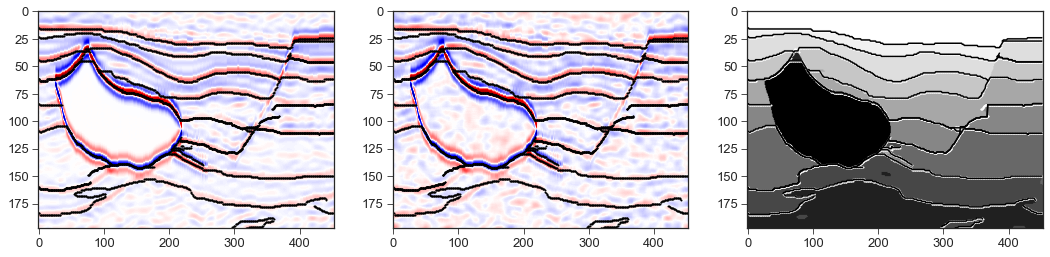

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.imshow(d, vmin=-0.3, vmax=0.3, aspect="auto", cmap='seismic')
for i,h in horizon_list.iterrows():  
    if h['chosen']:
        ax1.scatter(h['x'], h['y'], c='k', s=1)
ax1.axis('tight')

ax2.imshow(dn, vmin=-0.3, vmax=0.3, aspect="auto", cmap='seismic')
for i,h in horizon_list.iterrows():  
    if h['chosen']:
        ax2.scatter(h['x'], h['y'], c='k', s=1)
ax2.axis('tight')

ax3.imshow(vcljoint.reshape(nt0, nx), aspect="auto")
for i,h in horizon_list.iterrows():  
    if h['chosen']:
        ax3.scatter(h['x'], h['y'], c='w', s=1)
        ax3.plot(h['regx'], h['regy'], c='k')
ax3.axis('tight');

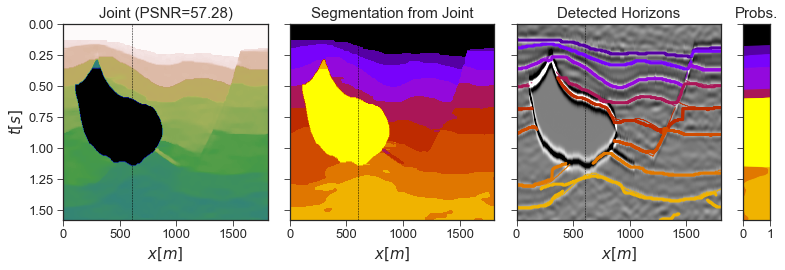

In [40]:
cmap_classes = 'gnuplot'
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(11, 4),
                        gridspec_kw={'width_ratios': [3, 3, 3, 0.4]})
axs[0].imshow(np.exp(mjoint).reshape(nt0, nx), vmin=1.2e7, vmax=2.9e7,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'Joint (PSNR=%.2f)' % psnr['J'][-1])
axs[1].imshow(vcljoint.reshape(nt0, nx), cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Segmentation from Joint')
axs[2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].axis('tight')
for ihor, horkey in enumerate(hors.keys()):
    axs[2].plot(np.arange(nx) * dx, hors[horkey]* dt0, 
                c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=1)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
        for hsel in horsel:
            axs[2].plot(hsel['regx']* dx, hsel['regy']* dt0,
                        c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=3)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('Detected Horizons')

norm = Normalize(vmin=0, vmax=ncl)
probs = vjoint.reshape(nt0, nx, ncl)[:, nx//3]
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((nt0, 1)), cdf))
for icl in range(ncl):
    axs[3].fill_betweenx(t0, cdf[:, icl], cdf[:, icl+1], 
                         color=cm.get_cmap(cmap_classes, ncl)(norm(icl)))
axs[3].set_xlim(0, 1)
axs[3].set_title('Probs.')
plt.tight_layout()
plt.savefig('Figs/Hesspert_joint.eps', dpi=150);

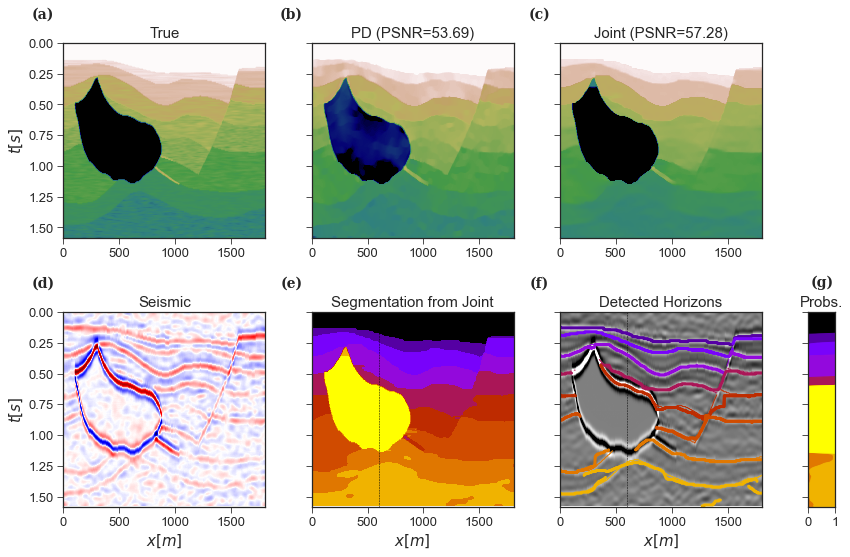

In [44]:
cmap='gist_earth_r'

fig, axs = plt.subplots(2, 4, sharey=True, 
                        gridspec_kw={'width_ratios': [3, 3, 3, .4]}, figsize=(12, 8))
axs[0][0].imshow(np.exp(mfine), vmin=1.2e7, vmax=2.9e7,
                  cmap=cmap, extent=(x[0], x[-1], t0fine[-1], t0fine[0]))
axs[0][0].axis('tight')
axs[0][0].set_ylabel(r'$t [s]$')
axs[0][0].set_title('True')
axs[0][0].text(-0.1, 1.13, '(a)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[0][0].transAxes)
axs[0][1].imshow(np.exp(mpd.reshape(nt0, nx)), vmin=1.2e7, vmax=2.9e7,
                 cmap=cmap, extent=(x[0], x[-1], t0fine[-1], t0fine[0]))
axs[0][1].axis('tight')
axs[0][1].set_title(r'PD (PSNR=%.2f)' % psnr['PD'])
axs[0][1].text(-0.1, 1.13, '(b)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[0][1].transAxes)
axs[0][2].imshow(np.exp(mjoint.reshape(nt0, nx)), vmin=1.2e7, vmax=2.9e7,
                 cmap=cmap, extent=(x[0], x[-1], t0fine[-1], t0fine[0]))
axs[0][2].axis('tight')
axs[0][2].set_title('Joint (PSNR=%.2f)' % psnr['J'][-1])
axs[0][2].text(-0.1, 1.13, '(c)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[0][2].transAxes)
axs[0][3].axis('off')
axs[1][0].imshow(dn, cmap='seismic', vmin=-0.3, vmax=0.3, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1][0].set_ylabel(r'$t [s]$')
axs[1][0].set_xlabel(r'$x [m]$')
axs[1][0].set_title('Seismic')
axs[1][0].axis('tight')
axs[1][0].text(-0.1, 1.13, '(d)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[1][0].transAxes)
axs[1][1].imshow(vcljoint.reshape(nt0, nx), cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
                 extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1][1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1][1].axis('tight')
axs[1][1].set_xlabel(r'$x [m]$')
axs[1][1].set_title('Segmentation from Joint')
axs[1][1].text(-0.1, 1.13, '(e)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[1][1].transAxes)
axs[1][2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1][2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1][2].axis('tight')
for ihor, horkey in enumerate(hors.keys()):
    axs[1][2].plot(np.arange(nx) * dx, hors[horkey]* dt0, 
                c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=1)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
        for hsel in horsel:
            axs[1][2].plot(hsel['regx']* dx, hsel['regy']* dt0,
                           c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=3)
axs[1][2].set_xlabel(r'$x [m]$')
axs[1][2].set_title('Detected Horizons')
axs[1][2].text(-0.1, 1.13, '(f)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[1][2].transAxes)
norm = Normalize(vmin=0, vmax=ncl)
probs = vjoint.reshape(nt0, nx, ncl)[:, nx//3]
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((nt0, 1)), cdf))
for icl in range(ncl):
    axs[1][3].fill_betweenx(t0, cdf[:, icl], cdf[:, icl+1], color=cm.get_cmap(cmap_classes, ncl)(norm(icl)))
axs[1][3].set_xlim(0, 1)
axs[1][3].set_title('Probs.')
axs[1][3].text(0.5, 1.13, '(g)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[1][3].transAxes)
plt.tight_layout()
plt.savefig('Figs/Hesspert_combined.eps', dpi=150);

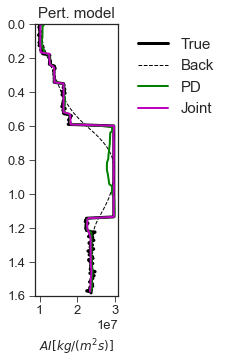

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 5))
ax.plot(np.exp(mfine[:, nx//3]), t0fine, 'k', lw=3, label='True')
ax.plot(np.exp(mback[:, nx//3]), t0, '--k', lw=1, label='Back')
ax.plot(np.exp(mpd[:, nx//3]), t0, 'g', lw=2, label='PD')
ax.plot(np.exp(mjoint.reshape(nt0, nx))[:, nx//3], t0, 'm', lw=2, label='Joint')
ax.set_xlabel(r'$AI [kg/(m^2s)]$', fontsize=12, labelpad=20.)
ax.set_title('Pert. model')
ax.set_ylim(1.6, 0)
ax.legend(bbox_to_anchor=(2.3, 1.))
plt.savefig('Figs/Hesspert_traces.eps', dpi=150, bbox_inches='tight');